In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import timm
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

from emsim.geant.dataset import (
    GeantElectronDataset,
    electron_collate_fn,
    plot_pixel_patch_and_points,
)
from emsim.geant.incidence_predictor import (
    GaussianIncidencePointPredictor,
    IncidencePointPredictor,
    eval_gaussian_model,
    eval_pointwise_model,
    fit_gaussian_patch_predictor,
    fit_pointwise_patch_predictor,
)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [22]:
pixels_file = "../data/pixelated_5um_tracks_thinned_4um_back_20k_300keV.txt"
trajectory_file = "../data/e300keV_thinned_4um_back_20k.txt"

### This value controls the background noise level

In [48]:
noise_std = 8

### Create training and test datasets

In [49]:
dataset = GeantElectronDataset(pixels_file, [128, 129], 7, noise_std=noise_std, trajectory_file=trajectory_file)
test_dataset = GeantElectronDataset(pixels_file, [128, 129], 7, noise_std=noise_std, trajectory_file=trajectory_file, split="test")

### Generate a test batch for debugging and plotting later

In [ ]:
test_loader = DataLoader(test_dataset, 1, collate_fn=electron_collate_fn)
test_batch = next(iter(test_loader))

### This creates an instance of the non-uncertainty-aware incidence point predictor

In [25]:
backbone = timm.create_model("resnet18", in_chans=1, num_classes=0)
model = IncidencePointPredictor(backbone).to(device)

### Train the non-uncertainty-aware incidence point predictor

In [27]:
fit_pointwise_patch_predictor(model, dataset, n_steps=1000)

100%|██████████| 1000/1000 [1:34:34<00:00,  5.67s/it, loss=0.00516]   


### Evaluate it on the test dataset

In [29]:
nn_errors, com_errors, nn_distances, com_distances = eval_pointwise_model(model, test_dataset)

In [30]:
# Print results
print(f"{nn_distances.mean()=}")
print(f"{com_distances.mean()=}")

nn_distances.mean()=0.6754306548976166
com_distances.mean()=0.826738174368193


### Plot an example prediction from the test dataset

In [4]:
# This selects which element from the test batch to plot
i = 34


model.eval()
with torch.no_grad():
    predicted_point = model(test_batch["pixel_patches"][i].unsqueeze(0).to(device)).cpu().numpy().squeeze()
    
fig, ax = plot_pixel_patch_and_points(
    test_batch["pixel_patches"][i].numpy(),
    [
        test_batch["local_incidence_points_pixels"][i].numpy(),
        test_batch["local_centers_of_mass_pixels"][i].numpy(),
        predicted_point
    ],
    ["True incidence point", "CoM estimate", "NN estimate"],
)
fig.set_size_inches(10, 8)
fig.show()

NameError: name 'model' is not defined

## Uncertainty-aware predictor

### Create the backbone and model

In [9]:
backbone = timm.create_model("resnet18", in_chans=1, num_classes=0)
model2 = GaussianIncidencePointPredictor(backbone).to(device)

### Train the model

In [11]:
nll_losses, rmse = fit_gaussian_patch_predictor(model2, dataset, n_steps=1000)

 48%|████▊     | 484/1000 [02:38<02:48,  3.06it/s, loss=2.33, rmse=0.498]   


ValueError: Expected parameter scale_tril (Tensor of shape (128, 2, 2)) of distribution MultivariateNormal(loc: torch.Size([128, 2]), scale_tril: torch.Size([128, 2, 2])) to satisfy the constraint LowerCholesky(), but found invalid values:
tensor([[[ 1.2853e-01,  0.0000e+00],
         [ 9.5603e-03,  1.3366e-01]],

        [[ 1.3904e-01,  0.0000e+00],
         [-4.1599e-03,  1.5870e-01]],

        [[ 2.6048e-01,  0.0000e+00],
         [-1.9787e-03,  2.5530e-01]],

        [[ 1.5827e-01,  0.0000e+00],
         [ 3.9029e-03,  1.5745e-01]],

        [[ 1.4679e-01,  0.0000e+00],
         [ 3.7903e-03,  1.4454e-01]],

        [[ 1.7400e-01,  0.0000e+00],
         [-4.7723e-03,  1.7717e-01]],

        [[ 1.5148e-01,  0.0000e+00],
         [ 8.5516e-03,  1.6271e-01]],

        [[ 1.6347e-01,  0.0000e+00],
         [-8.4147e-05,  1.6740e-01]],

        [[ 1.5326e-01,  0.0000e+00],
         [-6.9112e-03,  1.5448e-01]],

        [[ 1.4047e-01,  0.0000e+00],
         [-3.2557e-03,  1.4420e-01]],

        [[ 1.2478e-01,  0.0000e+00],
         [-4.2194e-03,  1.2278e-01]],

        [[ 1.5093e-01,  0.0000e+00],
         [ 1.2056e-02,  1.4162e-01]],

        [[ 1.3384e-01,  0.0000e+00],
         [ 1.1824e-03,  1.3707e-01]],

        [[ 2.3181e-01,  0.0000e+00],
         [-4.0905e-04,  2.2480e-01]],

        [[ 1.9691e-01,  0.0000e+00],
         [-2.2012e-03,  2.0194e-01]],

        [[ 1.6948e-01,  0.0000e+00],
         [ 6.6035e-03,  1.5144e-01]],

        [[ 2.5614e-01,  0.0000e+00],
         [ 2.3377e-02,  2.6350e-01]],

        [[ 2.0926e-01,  0.0000e+00],
         [ 1.9845e-02,  2.2357e-01]],

        [[ 1.4864e-01,  0.0000e+00],
         [ 3.7266e-03,  1.5274e-01]],

        [[ 1.5485e-01,  0.0000e+00],
         [ 3.6539e-04,  1.5773e-01]],

        [[ 1.3465e-01,  0.0000e+00],
         [ 5.8388e-03,  1.3870e-01]],

        [[ 1.7692e-01,  0.0000e+00],
         [-2.5358e-03,  1.7702e-01]],

        [[ 1.4258e-01,  0.0000e+00],
         [-8.0406e-04,  1.4639e-01]],

        [[ 1.6446e-01,  0.0000e+00],
         [ 3.0600e-03,  1.6751e-01]],

        [[ 1.6220e-01,  0.0000e+00],
         [ 6.1459e-03,  1.6721e-01]],

        [[ 1.5634e-01,  0.0000e+00],
         [ 7.2302e-03,  1.5418e-01]],

        [[ 2.0120e-01,  0.0000e+00],
         [ 3.9662e-04,  1.9874e-01]],

        [[ 2.0626e-01,  0.0000e+00],
         [-7.6711e-04,  2.0558e-01]],

        [[ 1.9252e-01,  0.0000e+00],
         [-2.6755e-03,  1.8402e-01]],

        [[ 2.2831e-01,  0.0000e+00],
         [-2.1255e-03,  2.2949e-01]],

        [[ 4.4587e+00,  0.0000e+00],
         [ 6.4631e-02,  6.5788e+00]],

        [[ 3.4153e-01,  0.0000e+00],
         [ 2.7900e-02,  3.7303e-01]],

        [[ 1.1356e+02,  0.0000e+00],
         [ 1.5314e-01,  1.2469e+02]],

        [[ 3.7363e+00,  0.0000e+00],
         [ 6.5080e-02,  4.5557e+00]],

        [[ 1.5907e-01,  0.0000e+00],
         [ 4.0216e-03,  1.6117e-01]],

        [[ 1.9467e-01,  0.0000e+00],
         [-6.5716e-04,  1.9238e-01]],

        [[ 7.6037e+00,  0.0000e+00],
         [ 6.4631e-02,  9.9072e+00]],

        [[ 1.7700e-01,  0.0000e+00],
         [-7.1838e-03,  1.9096e-01]],

        [[ 1.2737e-01,  0.0000e+00],
         [ 4.5758e-03,  1.2994e-01]],

        [[ 1.2956e-01,  0.0000e+00],
         [ 8.3875e-03,  1.3299e-01]],

        [[ 1.3733e-01,  0.0000e+00],
         [ 2.3596e-03,  1.4123e-01]],

        [[ 2.2397e-01,  0.0000e+00],
         [-1.7408e-03,  2.1890e-01]],

        [[ 1.7550e-01,  0.0000e+00],
         [-3.6573e-04,  1.8782e-01]],

        [[ 1.3565e-01,  0.0000e+00],
         [-6.7605e-03,  1.5210e-01]],

        [[ 1.5169e-01,  0.0000e+00],
         [-1.2325e-02,  1.7525e-01]],

        [[ 1.6392e-01,  0.0000e+00],
         [ 4.5796e-04,  1.6843e-01]],

        [[ 1.7409e-01,  0.0000e+00],
         [-7.8622e-03,  1.8571e-01]],

        [[ 1.3760e-01,  0.0000e+00],
         [ 1.0411e-03,  1.4006e-01]],

        [[ 1.9253e-01,  0.0000e+00],
         [-1.9268e-03,  1.9162e-01]],

        [[ 1.4284e-01,  0.0000e+00],
         [-4.3293e-03,  1.4260e-01]],

        [[        inf,         nan],
         [        nan,         inf]],

        [[ 1.9441e-01,  0.0000e+00],
         [-2.0877e-03,  2.3346e-01]],

        [[ 1.5171e-01,  0.0000e+00],
         [ 1.6249e-03,  1.7240e-01]],

        [[ 1.9593e-01,  0.0000e+00],
         [ 5.5945e-04,  2.0072e-01]],

        [[ 1.4313e-01,  0.0000e+00],
         [-5.6293e-04,  1.4943e-01]],

        [[ 1.3659e-01,  0.0000e+00],
         [-4.2419e-04,  1.3560e-01]],

        [[ 1.4496e-01,  0.0000e+00],
         [ 9.3691e-03,  1.4341e-01]],

        [[ 1.4107e-01,  0.0000e+00],
         [-7.1808e-03,  1.4055e-01]],

        [[ 1.6212e-01,  0.0000e+00],
         [-5.6341e-04,  1.6101e-01]],

        [[ 1.7445e-01,  0.0000e+00],
         [-1.2855e-03,  1.8550e-01]],

        [[ 1.2208e-01,  0.0000e+00],
         [ 3.9204e-03,  1.2739e-01]],

        [[ 1.6342e-01,  0.0000e+00],
         [ 2.3127e-03,  1.7080e-01]],

        [[ 1.3190e-01,  0.0000e+00],
         [ 2.5048e-03,  1.3421e-01]],

        [[ 1.3717e-01,  0.0000e+00],
         [ 1.3440e-03,  1.5056e-01]],

        [[ 1.4476e-01,  0.0000e+00],
         [ 4.5590e-03,  1.4257e-01]],

        [[ 1.7171e-01,  0.0000e+00],
         [ 2.3939e-03,  1.7279e-01]],

        [[ 1.8797e-01,  0.0000e+00],
         [ 2.6117e-03,  1.9708e-01]],

        [[ 1.4145e-01,  0.0000e+00],
         [ 3.4596e-03,  1.4023e-01]],

        [[ 1.5058e-01,  0.0000e+00],
         [-2.5266e-03,  1.5407e-01]],

        [[ 1.5560e-01,  0.0000e+00],
         [ 3.5786e-03,  1.5734e-01]],

        [[ 1.2725e-01,  0.0000e+00],
         [ 2.9237e-03,  1.3040e-01]],

        [[ 1.8633e-01,  0.0000e+00],
         [-2.2025e-03,  1.8898e-01]],

        [[ 1.4717e-01,  0.0000e+00],
         [ 8.4558e-04,  1.5692e-01]],

        [[ 1.4083e-01,  0.0000e+00],
         [ 4.3735e-03,  1.3966e-01]],

        [[ 2.1020e-01,  0.0000e+00],
         [-5.3146e-03,  2.0868e-01]],

        [[ 1.6164e-01,  0.0000e+00],
         [-7.0506e-04,  1.5952e-01]],

        [[ 1.7136e-01,  0.0000e+00],
         [ 1.4419e-02,  1.5918e-01]],

        [[ 1.7464e-01,  0.0000e+00],
         [-1.1232e-03,  1.7199e-01]],

        [[ 1.2771e-01,  0.0000e+00],
         [-4.7313e-04,  1.4384e-01]],

        [[ 1.7153e-01,  0.0000e+00],
         [ 5.8942e-03,  1.6476e-01]],

        [[ 2.1877e-01,  0.0000e+00],
         [-3.4684e-03,  2.2119e-01]],

        [[ 1.5357e-01,  0.0000e+00],
         [-8.1931e-04,  1.5220e-01]],

        [[ 6.5338e+01,  0.0000e+00],
         [ 1.3955e-01,  7.2182e+01]],

        [[ 1.7982e-01,  0.0000e+00],
         [ 4.3752e-03,  1.7507e-01]],

        [[ 7.1057e-01,  0.0000e+00],
         [ 3.9979e-02,  7.6572e-01]],

        [[ 1.6902e-01,  0.0000e+00],
         [ 1.4170e-02,  1.8180e-01]],

        [[ 1.7398e-01,  0.0000e+00],
         [ 6.5255e-03,  1.6988e-01]],

        [[ 2.0056e-01,  0.0000e+00],
         [ 1.0415e-03,  2.0708e-01]],

        [[ 1.6574e-01,  0.0000e+00],
         [ 4.1182e-03,  1.7185e-01]],

        [[ 1.5703e-01,  0.0000e+00],
         [-6.4782e-03,  1.6641e-01]],

        [[ 1.6234e-01,  0.0000e+00],
         [ 5.1680e-03,  1.5882e-01]],

        [[ 1.4056e-01,  0.0000e+00],
         [ 2.5430e-03,  1.4841e-01]],

        [[ 1.5009e-01,  0.0000e+00],
         [ 2.6355e-03,  1.6318e-01]],

        [[ 1.5117e-01,  0.0000e+00],
         [-4.5506e-03,  1.6617e-01]],

        [[ 1.5982e-01,  0.0000e+00],
         [ 2.9018e-04,  1.7420e-01]],

        [[ 1.4242e-01,  0.0000e+00],
         [-1.5064e-02,  1.4977e-01]],

        [[ 1.5856e-01,  0.0000e+00],
         [ 2.8071e-03,  1.7139e-01]],

        [[ 1.9258e-01,  0.0000e+00],
         [-4.6046e-03,  1.9682e-01]],

        [[ 1.5499e-01,  0.0000e+00],
         [ 4.5240e-03,  1.5729e-01]],

        [[ 1.6693e-01,  0.0000e+00],
         [-1.1557e-03,  1.6383e-01]],

        [[ 2.0290e-01,  0.0000e+00],
         [-1.6966e-03,  2.0705e-01]],

        [[ 1.6866e-01,  0.0000e+00],
         [ 3.2220e-03,  1.8170e-01]],

        [[ 1.8708e-01,  0.0000e+00],
         [ 4.4372e-04,  2.0375e-01]],

        [[ 1.6397e-01,  0.0000e+00],
         [ 6.9067e-03,  1.6153e-01]],

        [[ 1.5200e-01,  0.0000e+00],
         [-4.9966e-03,  1.6558e-01]],

        [[ 1.4887e-01,  0.0000e+00],
         [-2.0616e-03,  1.4472e-01]],

        [[ 2.2213e-01,  0.0000e+00],
         [ 7.9875e-04,  2.7606e-01]],

        [[ 1.8508e-01,  0.0000e+00],
         [ 6.1011e-03,  1.7360e-01]],

        [[ 2.0153e-01,  0.0000e+00],
         [-9.8959e-04,  2.0098e-01]],

        [[ 5.1441e-01,  0.0000e+00],
         [ 3.2997e-02,  5.8602e-01]],

        [[ 1.4092e-01,  0.0000e+00],
         [-9.8215e-04,  1.3815e-01]],

        [[ 1.6815e-01,  0.0000e+00],
         [-5.8622e-03,  1.6000e-01]],

        [[ 1.4110e-01,  0.0000e+00],
         [ 3.7998e-03,  1.4532e-01]],

        [[ 3.1867e-01,  0.0000e+00],
         [-2.4755e-03,  3.4526e-01]],

        [[ 1.2567e-01,  0.0000e+00],
         [ 1.0644e-03,  1.3245e-01]],

        [[ 1.3961e-01,  0.0000e+00],
         [-4.6986e-04,  1.4306e-01]],

        [[ 1.2833e-01,  0.0000e+00],
         [-1.7244e-03,  1.4279e-01]],

        [[ 1.9184e-01,  0.0000e+00],
         [-2.4742e-03,  1.8943e-01]],

        [[ 1.5266e-01,  0.0000e+00],
         [ 3.7705e-03,  1.4976e-01]],

        [[ 1.4637e-01,  0.0000e+00],
         [-5.9531e-03,  1.4748e-01]],

        [[ 1.3667e-01,  0.0000e+00],
         [ 1.8477e-03,  1.4209e-01]],

        [[ 1.9508e-01,  0.0000e+00],
         [ 1.6579e-03,  2.0333e-01]],

        [[ 1.5303e-01,  0.0000e+00],
         [-7.2118e-03,  1.5130e-01]],

        [[ 1.8708e-01,  0.0000e+00],
         [-1.3512e-03,  2.0249e-01]],

        [[ 2.0029e-01,  0.0000e+00],
         [ 5.0072e-04,  2.0925e-01]],

        [[ 1.5507e-01,  0.0000e+00],
         [-6.2239e-05,  1.5652e-01]],

        [[ 1.4886e-01,  0.0000e+00],
         [-4.1084e-03,  1.4666e-01]],

        [[ 1.3068e-01,  0.0000e+00],
         [ 1.0641e-03,  1.4271e-01]]], device='cuda:0',
       grad_fn=<ExpandBackward0>)

### Evaluate on the test dataset

In [17]:
nn_errors, com_errors, nn_distances, com_distances = eval_gaussian_model(model2, test_dataset)

In [18]:
print(f"{nn_distances.mean()=}")
print(f"{com_distances.mean()=}")

nn_distances.mean()=1.9013391279655052
com_distances.mean()=0.9745157531233294


### Example plotting code

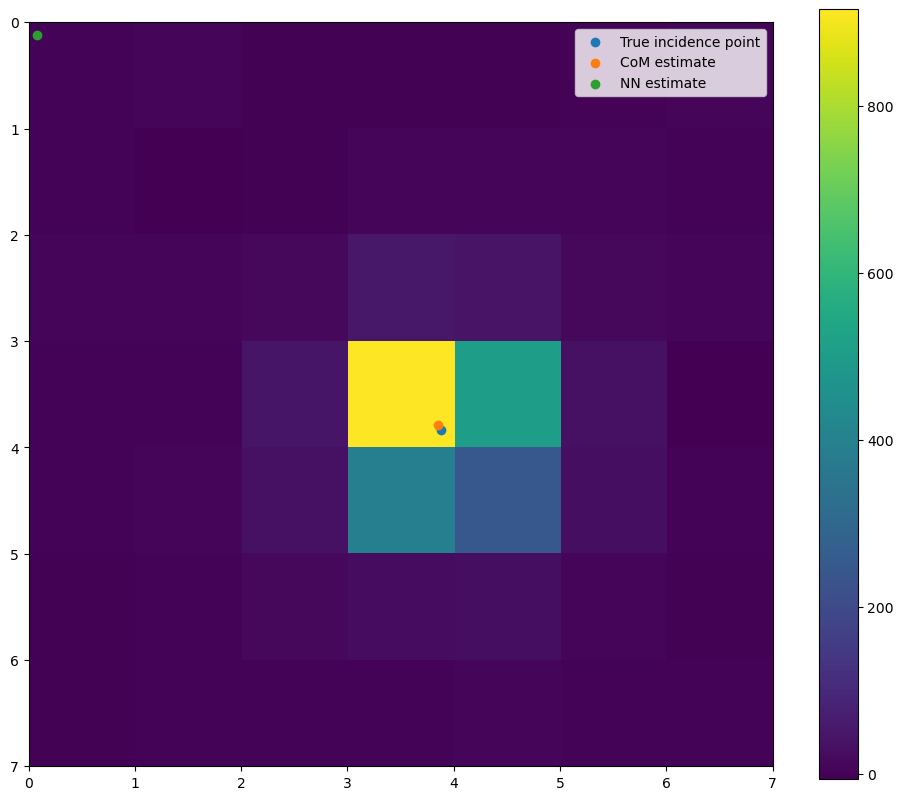

In [34]:
i = 11

model2.eval()
with torch.no_grad():
    dist = model2(test_batch["pixel_patches"].to(device))
    predicted_points = dist.mean.cpu().numpy().squeeze()
    covariances = dist.covariance_matrix.cpu().numpy().squeeze()
    
distances = ((dist.mean - test_batch["local_incidence_points_pixels"].to(device)) ** 2).sum(-1).sqrt()
    
X, Y = np.meshgrid(
    np.linspace(0, test_batch["pixel_patches"][i].shape[0], 300),
    np.linspace(0, test_batch["pixel_patches"][i].shape[1], 300),
)
Z = scipy.stats.multivariate_normal.pdf(np.stack([X, Y], -1), mean=predicted_points[i], cov=covariances[i])

fig, ax = plot_pixel_patch_and_points(
    test_batch["pixel_patches"][i].numpy(),
    [
        test_batch["local_incidence_points_pixels"][i].numpy(),
        test_batch["local_centers_of_mass_pixels"][i].numpy(),
        predicted_points[i]
    ],
    ["True incidence point", "CoM estimate", "NN estimate"],
    Z
)
fig.set_size_inches(12, 10)
fig.show()